In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from utils import db_connect

pd.set_option('display.max_columns', None)

engine = db_connect()

# bring in the data
main_df = pd.read_sql('SELECT * FROM combined_data', con=engine)

# function to mark whether a school was operational all five years of data
# creates our 'Currently operational' feature
def mark_always_operational(main_df):
    
    total_years = main_df['SURVYEAR'].nunique()
    
    main_df['SY_STATUS_TEXT'] = main_df['SY_STATUS_TEXT'].str.strip()
    
    operational_counts = (
        main_df[main_df['SY_STATUS_TEXT'] == 'Currently operational']
        .groupby('NCESSCH')['SURVYEAR']
        .nunique()
    )
    
    always_operational_schools = operational_counts[operational_counts == total_years].index
    
    main_df['concurrently_operational'] = main_df['NCESSCH'].isin(always_operational_schools)
    
    return main_df

# apply the function
mark_always_operational(main_df=main_df)

# drop records that were not fully operational across all five years
main_df = main_df[main_df['concurrently_operational'] != False]

# strip whitespace
for col in main_df.select_dtypes(include=["string"]).columns:
    main_df[col] = main_df[col].str.strip()

# begin defining data type conversion processes
# Change columns to floats
float_cols = ["X", "Y", "LATCOD", "LONCOD", "FTE", "STUTERATIO"]

# change columns to int
int_cols = [
    "OBJECTID", "GSLO", "GSHI",
    "TOTFRL", "FRELCH", "REDLCH", "DIRECTCERT",
    "PK", "KG", "G01", "G02", "G03", "G04", "G05", "G06",
    "G07", "G08", "G09", "G10", "G11", "G12", "G13",
    "UG", "AE",
    "TOTMENROL", "TOTFENROL", "TOTAL", "MEMBER",
    "AMALM", "AMALF", "AM",
    "ASALM", "ASALF", "AS",
    "BLALM", "BLALF", "BL",
    "HPALM", "HPALF", "HP",
    "HIALM", "HIALF", "HI",
    "TRALM", "TRALF", "TR",
    "WHALM", "WHALF", "WH"
]

# Change columns to strings
string_cols = [
    "NCESSCH", "SURVYEAR", "STABR", "LEAID", "ST_LEAID",
    "LEA_NAME", "SCH_NAME",
    "LSTREET1", "LSTREET2", "LCITY", "LSTATE",
    "LZIP", "LZIP4", "PHONE",
    "VIRTUAL", "SCHOOL_LEVEL", "SCHOOL_TYPE_TEXT",
    "STATUS", "SY_STATUS_TEXT", "ULOCALE", "NMCNTY",
    "CHARTER_TEXT", "LSTREET3", "TITLEI", "STITLEI", "MAGNET_TEXT"
]

# function to clean NCES error codes
def clean_nces_error_codes(main_df, cols):
    error_values = [
    "M", "N", "-1", "-2", "-9",
    "Missing", "Not applicable", "Not Applicable",
    -1, -2, -9
]
    main_df[cols] = main_df[cols].replace(error_values, np.nan)
    return main_df

# clean ALL columns 
cols = float_cols + int_cols + string_cols
main_df = clean_nces_error_codes(main_df, cols)

# convert floats safely
for col in float_cols:
    main_df[col] = pd.to_numeric(main_df[col], errors="coerce")

    # convert ints safely
for col in int_cols:
    main_df[col] = pd.to_numeric(main_df[col], errors="coerce").astype("Int64")

    # convert strings
for col in string_cols:
    main_df[col] = main_df[col].astype("string")

    # round coordinates
main_df["LATCOD"] = main_df["LATCOD"].round(4)
main_df["LONCOD"] = main_df["LONCOD"].round(4)

# extract start Year - convert to int for sorting
main_df['SURVYEAR'] = main_df['SURVYEAR'].str[:4].astype(int)

# removing virtual schools
main_df = main_df[main_df['VIRTUAL'].isin(['Not Virtual', 'Not a virtual school'])]

# drop the virtual feature
main_df.drop(columns='VIRTUAL', inplace=True)

# only keeping 'regular' public schools, removing: [ 'Career and Technical School',
# 'Special education school', 'Alternative Education School',
# 'Alternative/other school', 'Vocational school']
main_df = main_df[main_df['SCHOOL_TYPE_TEXT'].isin(['Regular school', 'Regular School'])]

# drop the SCHOOL_TYPE_TEXT feature
main_df.drop(columns='SCHOOL_TYPE_TEXT', inplace=True)

# define additional redundant columns
redundant_cols = ['X', 'Y', 'OBJECTID', 'ST_LEAID', 'LSTREET1', 'LSTREET2', 'LSTREET3', 
                  'LZIP4', 'PHONE', 'AMALM', 'AMALF', 'ASALM', 'ASALF', 
                  'BLALM', 'BLALF', 'HPALM', 'HPALF', 'HIALM', 'HIALF', 'TRALM', 'TRALF', 
                  'WHALM', 'WHALF', 'STABR', 'LCITY', 'LSTATE', 'LZIP', 'SCHOOL_LEVEL', 'GSLO', 'GSHI'
                  , 'STATUS', 'SY_STATUS_TEXT', 'NMCNTY', 'DIRECTCERT', 'AE', 'TOTFENROL', 'TOTMENROL']

# drop additional redundant cols
main_df = main_df.drop(columns=redundant_cols)

# replace na values with 0
main_df = main_df.fillna(0)

# Checking records against all five years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
filtered_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"main_df shape: {main_df.shape}")
print(f"filtered_df shape: {filtered_df.shape}")


Connection successful
main_df shape: (317361, 43)
filtered_df shape: (202600, 43)


In [265]:
# Checking records against all five years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
filtered_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"main_df shape: {main_df.shape}")
print(f"filtered_df shape: {filtered_df.shape}")

main_df shape: (461760, 82)
filtered_df shape: (461760, 82)


In [266]:
main_df['VIRTUAL'].unique()

<StringArray>
[                      'Not Virtual',                      'Full Virtual',
                                <NA>,              'Supplemental Virtual',
 'Virtual with face to face options',              'Not a virtual school',
                  'A virtual school']
Length: 7, dtype: string

In [267]:
# removing virtual schools
main_df = main_df[main_df['VIRTUAL'].isin(['Not Virtual', 'Not a virtual school'])]

In [268]:
# Checking records against all five years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
filtered_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"main_df shape: {main_df.shape}")
print(f"filtered_df shape: {filtered_df.shape}")

main_df shape: (343416, 82)
filtered_df shape: (220620, 82)


In [252]:
# drop the virtual feature
main_df.drop(columns='VIRTUAL', inplace=True)

In [255]:
filtered_df[filtered_df['NCESSCH'] == '40088603407']

,X,Y,OBJECTID,NCESSCH,SURVYEAR,STABR,LEAID,ST_LEAID,LEA_NAME,SCH_NAME,LSTREET1,LSTREET2,LSTREET3,LCITY,LSTATE,LZIP,LZIP4,PHONE,CHARTER_TEXT,MAGNET_TEXT,GSLO,GSHI,SCHOOL_LEVEL,TITLEI,STITLEI,STATUS,SCHOOL_TYPE_TEXT,SY_STATUS_TEXT,ULOCALE,NMCNTY,TOTFRL,FRELCH,REDLCH,DIRECTCERT,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,AE,TOTFENROL,TOTMENROL,TOTAL,MEMBER,FTE,STUTERATIO,AMALM,AMALF,AM,ASALM,ASALF,AS,BLALM,BLALF,BL,HPALM,HPALF,HP,HIALM,HIALF,HI,TRALM,TRALF,TR,WHALM,WHALF,WH,LATCOD,LONCOD,concurrently_operational
2,-111.889740,33.541458,2903,40088603407,2020,AZ,400886,AZ-92314,Archway Classical Academy Cicero (92314),Great Hearts Academies - Archway Cicero,3102 N 56TH ST,<NA>,<NA>,PHOENIX,AZ,85018,6606,(480)424-1790,Yes,<NA>,<NA>,5,Elementary,1-Yes,2-No,1,Regular school,Currently operational,41-Rural: Fringe,Maricopa County,<NA>,<NA>,<NA>,<NA>,<NA>,85,89,84,93,87,94,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,532,532,NaN,NaN,5,2,7,11,18,29,3,3,6,0,2,2,31,51,82,19,17,36,180,190,370,33.5415,-111.8897,True
134044,-111.889741,33.541458,2871,40088603407,2022,AZ,400886,AZ-92314,Archway Classical Academy Cicero (92314),Great Hearts Academies - Archway Cicero,3102 N 56TH ST,<NA>,<NA>,PHOENIX,AZ,85018,6606,(480)424-1790,Yes,<NA>,<NA>,5,Elementary,<NA>,<NA>,1,Regular School,Currently operational,41-Rural: Fringe,Maricopa County,<NA>,<NA>,<NA>,<NA>,<NA>,44,81,91,91,87,85,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,235,244,479,479,NaN,NaN,2,6,8,15,11,26,1,5,6,0,0,0,43,42,85,22,20,42,152,160,312,33.5415,-111.8897,True
143115,-111.889741,33.541458,2862,40088603407,2021,AZ,400886,AZ-92314,Archway Classical Academy Cicero (92314),Great Hearts Academies - Archway Cicero,3102 N 56TH ST,<NA>,<NA>,PHOENIX,AZ,85018,6606,(480)424-1790,Yes,<NA>,<NA>,5,Elementary,2-Title I targeted assistance school,2-No,1,Regular school,Currently operational,41-Rural: Fringe,Maricopa County,<NA>,<NA>,<NA>,<NA>,<NA>,84,90,88,87,90,88,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,527,527,NaN,NaN,3,6,9,6,17,23,1,5,6,0,1,1,53,51,104,20,22,42,175,167,342,33.5415,-111.8897,True
391742,-111.889709,33.541504,92813,40088603407,2018,AZ,400886,AZ-92314,Archway Classical Academy Cicero (92314),Great Hearts Academies - Archway Cicero,3102 N 56TH ST,<NA>,<NA>,PHOENIX,AZ,85018,6606,(602)438-7045,Yes,<NA>,<NA>,5,Elementary,<NA>,<NA>,1,Regular school,Currently operational,41-Rural: Fringe,Maricopa County,<NA>,<NA>,<NA>,<NA>,<NA>,78,87,91,89,92,92,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,252,277,529,529,NaN,NaN,4,0,4,11,19,30,6,4,10,0,4,4,25,42,67,14,13,27,192,195,387,33.5415,-111.8897,True
479333,-111.889741,33.541458,94882,40088603407,2017,AZ,400886,AZ-92314,Archway Classical Academy Cicero,Great Hearts Academies - Archway Cicero,3102 N. 56th Street,<NA>,<NA>,Phoenix,AZ,85018,,(480)424-1790,Yes,<NA>,<NA>,7,Elementary,<NA>,<NA>,1,Regular school,Currently operational,41-Rural: Fringe,Maricopa County,<NA>,<NA>,<NA>,<NA>,<NA>,84,85,92,88,86,85,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,289,231,520,520,NaN,NaN,2,0,2,10,21,31,5,4,9,2,7,9,29,49,78,10,10,20,173,198,371,33.5415,-111.8897,True


In [269]:
main_df['SCHOOL_TYPE_TEXT'].unique()

<StringArray>
[              'Regular school',     'Special education school',
  'Career and Technical School', 'Alternative Education School',
               'Regular School',     'Special Education School',
     'Alternative/other school',            'Vocational school']
Length: 8, dtype: string

In [270]:
# only keeping 'regular' public schools, removing: [ 'Career and Technical School',
# 'Special education school', 'Alternative Education School',
# 'Alternative/other school', 'Vocational school']
main_df = main_df[main_df['SCHOOL_TYPE_TEXT'].isin(['Regular school', 'Regular School'])]

In [263]:
main_df[main_df['NCESSCH'] == '40088603407']

,X,Y,OBJECTID,NCESSCH,SURVYEAR,STABR,LEAID,ST_LEAID,LEA_NAME,SCH_NAME,LSTREET1,LSTREET2,LSTREET3,LCITY,LSTATE,LZIP,LZIP4,PHONE,CHARTER_TEXT,MAGNET_TEXT,GSLO,GSHI,SCHOOL_LEVEL,TITLEI,STITLEI,STATUS,SCHOOL_TYPE_TEXT,SY_STATUS_TEXT,ULOCALE,NMCNTY,TOTFRL,FRELCH,REDLCH,DIRECTCERT,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,AE,TOTFENROL,TOTMENROL,TOTAL,MEMBER,FTE,STUTERATIO,AMALM,AMALF,AM,ASALM,ASALF,AS,BLALM,BLALF,BL,HPALM,HPALF,HP,HIALM,HIALF,HI,TRALM,TRALF,TR,WHALM,WHALF,WH,LATCOD,LONCOD,concurrently_operational
2,-111.889740,33.541458,2903,40088603407,2020,AZ,400886,AZ-92314,Archway Classical Academy Cicero (92314),Great Hearts Academies - Archway Cicero,3102 N 56TH ST,<NA>,<NA>,PHOENIX,AZ,85018,6606,(480)424-1790,Yes,<NA>,<NA>,5,Elementary,1-Yes,2-No,1,Regular school,Currently operational,41-Rural: Fringe,Maricopa County,<NA>,<NA>,<NA>,<NA>,<NA>,85,89,84,93,87,94,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,532,532,NaN,NaN,5,2,7,11,18,29,3,3,6,0,2,2,31,51,82,19,17,36,180,190,370,33.5415,-111.8897,True
143115,-111.889741,33.541458,2862,40088603407,2021,AZ,400886,AZ-92314,Archway Classical Academy Cicero (92314),Great Hearts Academies - Archway Cicero,3102 N 56TH ST,<NA>,<NA>,PHOENIX,AZ,85018,6606,(480)424-1790,Yes,<NA>,<NA>,5,Elementary,2-Title I targeted assistance school,2-No,1,Regular school,Currently operational,41-Rural: Fringe,Maricopa County,<NA>,<NA>,<NA>,<NA>,<NA>,84,90,88,87,90,88,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,527,527,NaN,NaN,3,6,9,6,17,23,1,5,6,0,1,1,53,51,104,20,22,42,175,167,342,33.5415,-111.8897,True
391742,-111.889709,33.541504,92813,40088603407,2018,AZ,400886,AZ-92314,Archway Classical Academy Cicero (92314),Great Hearts Academies - Archway Cicero,3102 N 56TH ST,<NA>,<NA>,PHOENIX,AZ,85018,6606,(602)438-7045,Yes,<NA>,<NA>,5,Elementary,<NA>,<NA>,1,Regular school,Currently operational,41-Rural: Fringe,Maricopa County,<NA>,<NA>,<NA>,<NA>,<NA>,78,87,91,89,92,92,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,252,277,529,529,NaN,NaN,4,0,4,11,19,30,6,4,10,0,4,4,25,42,67,14,13,27,192,195,387,33.5415,-111.8897,True
479333,-111.889741,33.541458,94882,40088603407,2017,AZ,400886,AZ-92314,Archway Classical Academy Cicero,Great Hearts Academies - Archway Cicero,3102 N. 56th Street,<NA>,<NA>,Phoenix,AZ,85018,,(480)424-1790,Yes,<NA>,<NA>,7,Elementary,<NA>,<NA>,1,Regular school,Currently operational,41-Rural: Fringe,Maricopa County,<NA>,<NA>,<NA>,<NA>,<NA>,84,85,92,88,86,85,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,289,231,520,520,NaN,NaN,2,0,2,10,21,31,5,4,9,2,7,9,29,49,78,10,10,20,173,198,371,33.5415,-111.8897,True


In [271]:
# Checking records against all five years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
filtered_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()
print(counts)
print(f"main_df shape: {main_df.shape}")
print(f"filtered_df shape: {filtered_df.shape}")

NCESSCH
40943000155    5
40532000441    5
40497000409    5
40497000580    5
40095403513    5
              ..
64059002846    1
64059006709    1
64059009648    1
60000908779    1
63459005715    1
Name: count, Length: 84881, dtype: Int64
main_df shape: (317361, 82)
filtered_df shape: (202600, 82)


In [198]:
# drop the SCHOOL_TYPE_TEXT feature
main_df.drop(columns='SCHOOL_TYPE_TEXT', inplace=True)

In [199]:
# define additional redundant columns
redundant_cols = ['X', 'Y', 'OBJECTID', 'ST_LEAID', 'LSTREET1', 'LSTREET2', 'LSTREET3', 
                  'LZIP4', 'PHONE', 'AMALM', 'AMALF', 'ASALM', 'ASALF', 
                  'BLALM', 'BLALF', 'HPALM', 'HPALF', 'HIALM', 'HIALF', 'TRALM', 'TRALF', 
                  'WHALM', 'WHALF', 'STABR', 'LCITY', 'LSTATE', 'LZIP', 'SCHOOL_LEVEL', 'GSLO', 'GSHI'
                  , 'STATUS', 'SY_STATUS_TEXT', 'NMCNTY', 'DIRECTCERT', 'AE', 'TOTFENROL', 'TOTMENROL']

In [200]:
main_df = main_df.drop(columns=redundant_cols)

In [201]:
# replace na values with 0
main_df = main_df.fillna(0)

In [202]:
main_df.shape

(172632, 41)

In [204]:
counts = main_df["NCESSCH"].value_counts()
counts

NCESSCH
551485002954    4
50008201186     4
50040501157     4
50041900905     4
50255000026     4
               ..
110003000158    1
110003000160    1
110003000161    1
110003000163    1
110003000164    1
Name: count, Length: 61791, dtype: Int64

In [203]:
# ensure all records contain at minimum 5 years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
filtered_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()
filtered_df.shape

(0, 41)

In [85]:
main_df['TITLEI'].unique()

array(['2-No', '1-Yes', 0,
       '3-Title I schoolwide eligible-Title I targeted assistance program',
       '6-Not a Title I school', '2-Title I targeted assistance school',
       '5-Title I schoolwide school',
       '4-Title I schoolwide eligible school-No program',
       '1-Title I targeted assistance eligible school-No program'],
      dtype=object)

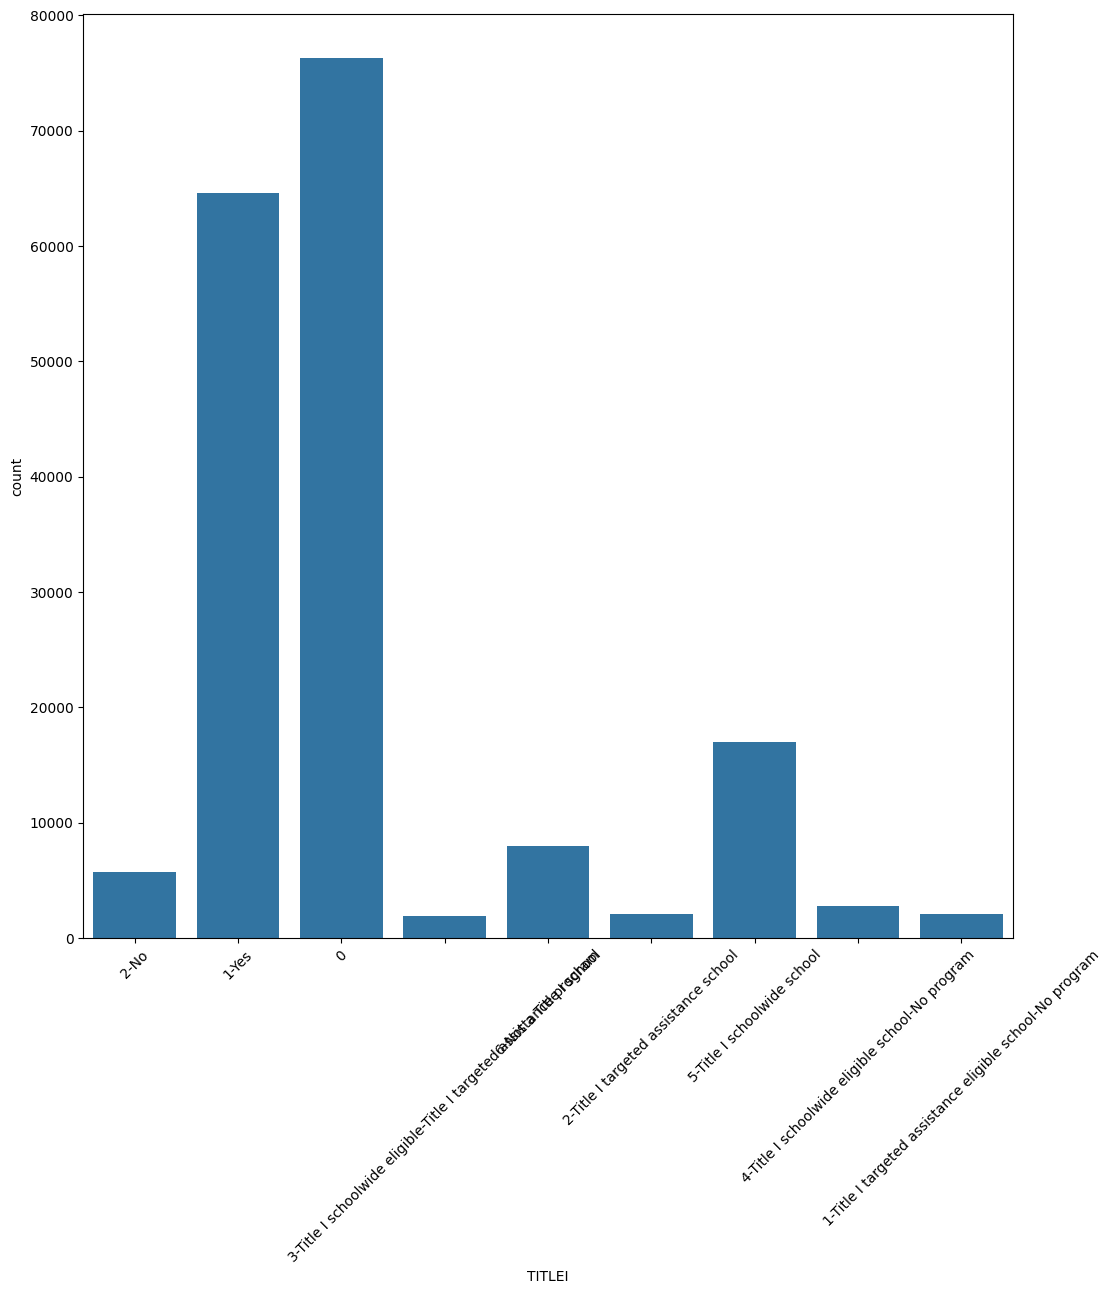

In [89]:
plt.figure(figsize=(12,12))
sns.countplot(data=main_df, x='TITLEI')
plt.xticks(rotation=45)
plt.show()

In [90]:
main_df['ULOCALE'].unique()

<StringArray>
[   '43-Rural: Remote',    '32-Town: Distant',    '21-Suburb: Large',
    '41-Rural: Fringe',     '33-Town: Remote',   '42-Rural: Distant',
      '13-City: Small', '22-Suburb: Mid-size',     '31-Town: Fringe',
    '23-Suburb: Small',   '12-City: Mid-size',      '11-City: Large']
Length: 12, dtype: string

In [92]:
# Simplify ULOCALE
main_df["locale_category"] = main_df["ULOCALE"].str.split("-").str[1].str.split(":").str[0]

In [93]:
main_df["locale_category"].unique()

array(['Rural', 'Town', 'Suburb', 'City'], dtype=object)

In [94]:
# Drop the ULOCALE feature
main_df.drop(columns='ULOCALE', inplace=True)

In [96]:
main_df.head()

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,TITLEI,STITLEI,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,MEMBER,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,concurrently_operational,locale_category
2602,80411000568,2020,804110,Fowler School District No. R4J,Fowler High School,2-No,0,64,41,23,0,0,0,0,0,0,0,0,0,0,28,27,28,30,0,0,113,113,11.23,10.06,0,0,0,0,25,1,87,38.1276,-104.0301,True,Rural
3396,50243000021,2020,502430,ARKADELPHIA SCHOOL DISTRICT,PEAKE ELEMENTARY SCHOOL,1-Yes,1-Yes,221,182,39,0,0,0,0,125,137,116,0,0,0,0,0,0,0,0,0,378,378,22.65,16.69,0,6,153,0,22,16,181,34.1227,-93.0688,True,Town
3548,80561000967,2020,805610,Meeker School District Re1,Meeker High School,2-No,0,59,51,8,0,0,0,0,0,0,0,0,0,0,73,49,48,46,0,0,216,216,14.52,14.88,3,0,0,0,23,0,190,40.0414,-107.9050,True,Rural
3601,80609001952,2020,806090,Pritchett School District No. Re-3,Pritchett Middle School,1-Yes,1-Yes,11,7,4,0,0,0,0,0,0,0,5,4,6,0,0,0,0,0,0,15,15,1.71,8.77,0,0,0,0,3,0,12,37.3727,-102.8622,True,Rural
3614,80690006435,2020,806900,Adams 12 Five Star Schools,Adams12 Five Star Preschool,2-No,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,0.00,0.00,0,3,0,0,24,1,22,39.9267,-104.9666,True,Suburb


In [98]:
# Title I status breakdown
main_df['TITLEI'].unique()

array(['2-No', '1-Yes', 0,
       '3-Title I schoolwide eligible-Title I targeted assistance program',
       '6-Not a Title I school', '2-Title I targeted assistance school',
       '5-Title I schoolwide school',
       '4-Title I schoolwide eligible school-No program',
       '1-Title I targeted assistance eligible school-No program'],
      dtype=object)

In [103]:
main_df[main_df['TITLEI'] == 0].shape

(76303, 41)

In [ ]:
# Title I rough breakdown:

# Participating:
# 1 - Yes - School participates in Title I funding / programs
# 5 - Title I schoolwide school - ENTIRE school recieves Title I support. Funds can be used for all students
# 2 - Title I targeted assistance school - Only SPECIFIC eligible students recieve services (usually low-income or academically at risk)

# Eligible, but no program running:
# 4 - Title I schoolwide eligible school - no program - Enough low-income students to qualify for schoolwide funding, but not using it
# 1 - Title I targeted assistance eligible school - No program - Eligible for targeted assistance but not participating

# Hybrid
# 3 Title I schoolwide eligible - Title I targeted assitance program - School qualifies for schoolwide funding but has chosen to run only a targeted program

# Explicit non-participation
# 2 - No - School does not participate
# 6 - Not a Title I school

# 0
# 0 - Assuming missing, unknown, or not reported


# Conceptual differences:
# Schoolwide = whole school qualifies = High funding flexibility - Typical poverty threshold >= 40% low-income
# Targeted = only some students qualify = Limited funding flexibility - lower threshold for poverty


In [105]:
schoolwide = ['1-Yes', '5-Title I schoolwide school']
targeted = ['2-Title I targeted assistance school', '3-Title I schoolwide eligible-Title I targeted assistance program']
elig_no_participate = ['4-Title I schoolwide eligible school-No program', 
                       '1-Title I targeted assistance eligible school-No program']
not_elig = ['2-No', '6-Not a Title I school']
missing = [0]

def group_titlei(col_TITLEI):
    if col_TITLEI in missing:
        return "Unknown"
    elif col_TITLEI in schoolwide:
        return "Schoolwide"
    elif col_TITLEI in targeted:
        return "Targeted"
    elif col_TITLEI in elig_no_participate:
        return "Eligible_No_Program"
    elif col_TITLEI in not_elig:
        return "Not_Eligible"
    else:
        return "Error"

In [106]:
main_df['TITLEI_GROUPED'] = main_df['TITLEI'].apply(group_titlei)

In [107]:
main_df.head()

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,TITLEI,STITLEI,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,MEMBER,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,concurrently_operational,locale_category,TITLEI_GROUPED
2602,80411000568,2020,804110,Fowler School District No. R4J,Fowler High School,2-No,0,64,41,23,0,0,0,0,0,0,0,0,0,0,28,27,28,30,0,0,113,113,11.23,10.06,0,0,0,0,25,1,87,38.1276,-104.0301,True,Rural,Not_Eligible
3396,50243000021,2020,502430,ARKADELPHIA SCHOOL DISTRICT,PEAKE ELEMENTARY SCHOOL,1-Yes,1-Yes,221,182,39,0,0,0,0,125,137,116,0,0,0,0,0,0,0,0,0,378,378,22.65,16.69,0,6,153,0,22,16,181,34.1227,-93.0688,True,Town,Schoolwide
3548,80561000967,2020,805610,Meeker School District Re1,Meeker High School,2-No,0,59,51,8,0,0,0,0,0,0,0,0,0,0,73,49,48,46,0,0,216,216,14.52,14.88,3,0,0,0,23,0,190,40.0414,-107.9050,True,Rural,Not_Eligible
3601,80609001952,2020,806090,Pritchett School District No. Re-3,Pritchett Middle School,1-Yes,1-Yes,11,7,4,0,0,0,0,0,0,0,5,4,6,0,0,0,0,0,0,15,15,1.71,8.77,0,0,0,0,3,0,12,37.3727,-102.8622,True,Rural,Schoolwide
3614,80690006435,2020,806900,Adams 12 Five Star Schools,Adams12 Five Star Preschool,2-No,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,0.00,0.00,0,3,0,0,24,1,22,39.9267,-104.9666,True,Suburb,Not_Eligible


In [ ]:
main_df[(main_df['TITLEI'] == '2-No') &
    (main_df['STITLEI'] != '2-No') &
    (main_df['STUTERATIO'] <= 1.0)].head(10) 

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,TITLEI,STITLEI,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,MEMBER,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,concurrently_operational,locale_category,TITLEI_GROUPED
3614,80690006435,2020,806900,Adams 12 Five Star Schools,Adams12 Five Star Preschool,2-No,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,0.0,0.0,0,3,0,0,24,1,22,39.9267,-104.9666,True,Suburb,Not_Eligible
53012,80228001982,2020,802280,Aspen School District No. 1 in the county of P...,Aspen Preschool,2-No,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,18,0.0,0.0,0,0,0,2,8,0,8,39.1909,-106.8493,True,Town,Not_Eligible
54013,80309000235,2020,803090,Montezuma-Cortez School District No. Re-1,Beech Street Preschool,2-No,0,45,38,7,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67,67,0.0,0.0,11,0,0,0,22,5,29,37.3544,-108.5834,True,Town,Not_Eligible
56596,80435006487,2020,804350,Mesa County Valley School District No. 51,Career Center Preschool,2-No,0,0,0,0,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,134,134,0.0,0.0,0,2,1,1,47,4,79,39.0758,-108.5089,True,City,Not_Eligible
56636,80441006741,2020,804410,GreeleySchool District No. 6 in the county of ...,ECC Aims District 6 Preschool,2-No,0,0,0,0,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,119,119,0.0,0.0,0,5,3,0,62,4,45,40.4081,-104.7691,False,City,Not_Eligible
58294,80540006558,2020,805400,Thompson School District R-2J,LEAP School,2-No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,40.4177,-105.1042,False,Suburb,Not_Eligible
58299,80546006540,2020,805460,Mancos School District Re-6,Mancos Early Learning Center,2-No,0,11,9,2,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,28,0.0,0.0,1,1,1,0,4,0,21,37.3445,-108.2911,True,Rural,Not_Eligible
58307,80555000959,2020,805550,Mapleton School District No. 1 in the county o...,Valley View K-8,2-No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,39.8231,-104.9954,False,Suburb,Not_Eligible
59416,80723006721,2020,807230,Westminster Public Schools,Early Learning Center at Perl Mack,2-No,0,3,3,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,31,0.0,0.0,0,0,0,0,9,3,19,39.8257,-105.0040,False,Suburb,Not_Eligible
65284,120003002975,2020,1200030,ALACHUA,FEARNSIDE FAMILY SERVICES CENTER,2-No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,29.6859,-82.3072,True,City,Not_Eligible


In [113]:
main_df[main_df['STITLEI'] != 0]

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,TITLEI,STITLEI,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,MEMBER,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,concurrently_operational,locale_category,TITLEI_GROUPED
3396,50243000021,2020,502430,ARKADELPHIA SCHOOL DISTRICT,PEAKE ELEMENTARY SCHOOL,1-Yes,1-Yes,221,182,39,0,0,0,0,125,137,116,0,0,0,0,0,0,0,0,0,378,378,22.650000,16.69,0,6,153,0,22,16,181,34.1227,-93.0688,True,Town,Schoolwide
3601,80609001952,2020,806090,Pritchett School District No. Re-3,Pritchett Middle School,1-Yes,1-Yes,11,7,4,0,0,0,0,0,0,0,5,4,6,0,0,0,0,0,0,15,15,1.710000,8.77,0,0,0,0,3,0,12,37.3727,-102.8622,True,Rural,Schoolwide
4095,50243000022,2020,502430,ARKADELPHIA SCHOOL DISTRICT,LOUISA PERRITT PRIMARY,1-Yes,1-Yes,279,243,36,0,146,141,135,0,0,0,0,0,0,0,0,0,0,0,0,422,422,27.780001,15.19,0,4,149,0,30,29,210,34.1130,-93.0739,True,Town,Schoolwide
5393,50000100218,2020,500001,DEWITT SCHOOL DISTRICT,DEWITT ELEMENTARY SCHOOL,1-Yes,1-Yes,324,274,50,20,87,61,82,78,78,92,0,0,0,0,0,0,0,0,0,498,498,35.470001,14.04,0,2,58,0,25,25,388,34.2756,-91.3493,True,Rural,Schoolwide
5394,50000100391,2020,500001,DEWITT SCHOOL DISTRICT,GILLETT ELEMENTARY SCHOOL,1-Yes,1-Yes,46,29,17,13,12,6,12,5,9,10,0,0,0,0,0,0,0,0,0,67,67,7.420000,9.03,0,0,7,0,5,0,55,34.1142,-91.3828,False,Rural,Schoolwide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504686,484473013666,2017,4844730,WAXAHACHIE ISD,TURNER PREKINDERGARTEN ACADEMY,0,Yes,151,134,17,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,188,188,11.000000,17.09,2,2,27,0,90,5,62,32.3816,-96.8303,False,Suburb,Unknown
504688,484668013620,2017,4846680,YSLETA ISD,PARKLAND PRE K CENTER,0,Yes,266,219,47,347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,347,347,13.000000,26.69,1,4,14,0,294,8,26,31.9027,-106.4032,False,City,Unknown
504809,560624000577,2017,5606240,Washakie County School District #1,West Side Elementary,0,Yes,77,62,15,0,0,0,0,0,88,107,0,0,0,0,0,0,0,0,0,195,195,17.799999,10.96,2,0,1,0,52,4,136,44.0089,-107.9619,False,Town,Unknown
504810,560624000578,2017,5606240,Washakie County School District #1,South Side Elementary,0,Yes,85,66,19,0,0,0,85,80,0,0,0,0,0,0,0,0,0,0,0,165,165,16.420000,10.05,0,0,1,0,47,3,114,44.0119,-107.9518,False,Town,Unknown


In [ ]:
# "STITLEI" is used to indicate whether the school is eligible for school wide funding assistance through title i.. need to find a way 
# to utlizize this feature information alongside the "TITLEI" feature as well.
main_df['STITLEI'].unique()

array([0, '1-Yes', '2-No', 'Yes', 'No'], dtype=object)

In [115]:
# First let's standardize the "STITLEI" column
STITLEI_yes = ['1-Yes', 'Yes']
STITLEI_no = ['2-No', 'No']
STITLEI_unknown = [0]

def standardize_STITLEI(col_STITLEI):
    if col_STITLEI in STITLEI_yes:
        return 'Yes'
    elif col_STITLEI in STITLEI_no:
        return 'No'
    elif col_STITLEI in STITLEI_unknown:
        return 'Unknown'
    else:
        return 'Error'

In [116]:
main_df['STITLEI'] = main_df['STITLEI'].apply(standardize_STITLEI)

In [117]:
main_df['STITLEI'].unique()

array(['Unknown', 'Yes', 'No'], dtype=object)

In [118]:
# Now we need to see if these two columns have any contradictions
main_df['TITLEI'].unique()

array(['2-No', '1-Yes', 0,
       '3-Title I schoolwide eligible-Title I targeted assistance program',
       '6-Not a Title I school', '2-Title I targeted assistance school',
       '5-Title I schoolwide school',
       '4-Title I schoolwide eligible school-No program',
       '1-Title I targeted assistance eligible school-No program'],
      dtype=object)

In [ ]:
print("""TITLEI column and STITLEI column may have contradictions. 
      It's possible to use the STITLEI column to indicate whether a school should belong in a specific TITLEI group. 
      If TITLEI states 1-Yes, but STITLEI states No, this is an indicator that the school belongs in the 'Targeted' group""")
print("Checking for contradictions between feature columns: TITLEI, STITLEI:")
print(f"count of rows where TITLEI is '2-No' and STITLEI is 'Yes': {main_df[(main_df['TITLEI'] == '2-No') & (main_df['STITLEI'] == 'Yes')].shape[0]}")
print(f"count of rows where TITLEI is '1-Yes' and STITLEI is 'No': {main_df[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No')].shape[0]}")
print(f"count of rows where TITLEI is '1-Yes' and STITLEI is 'No': {main_df[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No')].shape[0]}")

TITLEI column and STITLEI column may have contradictions. 
      It's possible to use the STITLEI column to indicate whether a school should belong in a specific TITLEI group. 
      If TITLEI states 1-Yes, but STITLEI states No, this is an indicator that the school belongs in the 'Targeted' group
Checking for contradictions between feature columns: TITLEI, STITLEI:
count of rows where TITLEI is '2-No' and STITLEI is 'Yes': 0
count of rows where TITLEI is '1-Yes' and STITLEI is 'No': 10107


In [ ]:
# What Public School characteristics point towards a "high strained system" ie high student teacher ratio?

In [138]:
main_df[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No')]

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,TITLEI,STITLEI,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,MEMBER,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,concurrently_operational,locale_category,TITLEI_GROUPED
9100,50296000066,2020,502960,BENTON SCHOOL DISTRICT,PERRIN ELEMENTARY SCHOOL,1-Yes,No,188,142,46,0,101,101,117,114,135,0,0,0,0,0,0,0,0,0,0,568,568,33.950001,16.73,0,2,46,1,31,28,460,34.5762,-92.5690,True,Suburb,Schoolwide
9116,50306001080,2020,503060,BENTONVILLE SCHOOL DISTRICT,CENTRAL PARK AT MORNING STAR,1-Yes,No,182,135,47,0,144,150,164,152,158,0,0,0,0,0,0,0,0,0,0,768,768,41.049999,18.71,12,68,18,8,103,38,521,36.3177,-94.2301,True,Rural,Schoolwide
9122,50306001462,2020,503060,BENTONVILLE SCHOOL DISTRICT,COOPER ELEMENTARY SCHOOL,1-Yes,No,163,122,41,0,144,106,148,114,143,0,0,0,0,0,0,0,0,0,0,655,655,36.080002,18.15,5,8,9,3,73,26,531,36.4372,-94.2304,True,Suburb,Schoolwide
9128,50306001649,2020,503060,BENTONVILLE SCHOOL DISTRICT,OSAGE CREEK ELEMENTARY SCHOOL,1-Yes,No,151,120,31,0,114,139,108,140,115,0,0,0,0,0,0,0,0,0,0,616,616,35.070000,17.56,9,110,38,3,75,40,341,36.3420,-94.2427,False,City,Schoolwide
9130,50306001691,2020,503060,BENTONVILLE SCHOOL DISTRICT,GRIMSLEY JUNIOR HIGH SCHOOL,1-Yes,No,215,164,51,0,0,0,0,0,0,0,0,394,385,0,0,0,0,0,0,779,779,58.560001,13.30,8,40,37,2,118,47,527,36.3467,-94.3017,False,Rural,Schoolwide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415242,481623013841,2018,4816230,DALLAS ISD,SOLAR PREP FOR BOYS AT JOHN F KENNEDY,1-Yes,No,110,110,0,32,71,57,60,0,0,0,0,0,0,0,0,0,0,0,0,220,220,14.480000,15.20,2,7,47,0,93,9,62,32.8098,-96.7743,False,City,Schoolwide
415531,530420003634,2018,5304200,Lake Stevens School District,Stevens Creek Elementary,1-Yes,No,150,112,38,0,99,95,97,112,112,98,0,0,0,0,0,0,0,0,0,613,613,36.509998,16.80,1,27,22,0,125,49,387,48.0244,-122.1061,False,Suburb,Schoolwide
415533,530423003640,2018,5304230,Lake Washington School District,Clara Barton Elementary School,1-Yes,No,97,80,17,4,83,88,86,101,95,70,0,0,0,0,0,0,0,0,0,527,527,33.830002,15.60,0,241,17,0,83,29,156,47.7092,-122.1120,False,City,Schoolwide
415538,530735003660,2018,5307350,Ridgefield School District,Sunset Ridge Intermediate School,1-Yes,No,132,97,35,0,0,0,0,0,0,286,253,0,0,0,0,0,0,0,0,539,539,26.209999,20.60,1,3,5,0,69,24,434,45.7935,-122.7116,False,Rural,Schoolwide


In [135]:
sliced_df = main_df[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No')]

In [136]:
sliced_df['TITLEI_GROUPED'].unique()

array(['Schoolwide'], dtype=object)

In [139]:
# UPDATE T 
# SET TITLEI_GROUPED = 'Targeted'
# FROM main_df[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No')] T


main_df.loc[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No'), 'TITLEI_GROUPED'] = 'Targeted'

In [140]:
main_df[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No')]

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,TITLEI,STITLEI,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,MEMBER,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,concurrently_operational,locale_category,TITLEI_GROUPED
9100,50296000066,2020,502960,BENTON SCHOOL DISTRICT,PERRIN ELEMENTARY SCHOOL,1-Yes,No,188,142,46,0,101,101,117,114,135,0,0,0,0,0,0,0,0,0,0,568,568,33.950001,16.73,0,2,46,1,31,28,460,34.5762,-92.5690,True,Suburb,Targeted
9116,50306001080,2020,503060,BENTONVILLE SCHOOL DISTRICT,CENTRAL PARK AT MORNING STAR,1-Yes,No,182,135,47,0,144,150,164,152,158,0,0,0,0,0,0,0,0,0,0,768,768,41.049999,18.71,12,68,18,8,103,38,521,36.3177,-94.2301,True,Rural,Targeted
9122,50306001462,2020,503060,BENTONVILLE SCHOOL DISTRICT,COOPER ELEMENTARY SCHOOL,1-Yes,No,163,122,41,0,144,106,148,114,143,0,0,0,0,0,0,0,0,0,0,655,655,36.080002,18.15,5,8,9,3,73,26,531,36.4372,-94.2304,True,Suburb,Targeted
9128,50306001649,2020,503060,BENTONVILLE SCHOOL DISTRICT,OSAGE CREEK ELEMENTARY SCHOOL,1-Yes,No,151,120,31,0,114,139,108,140,115,0,0,0,0,0,0,0,0,0,0,616,616,35.070000,17.56,9,110,38,3,75,40,341,36.3420,-94.2427,False,City,Targeted
9130,50306001691,2020,503060,BENTONVILLE SCHOOL DISTRICT,GRIMSLEY JUNIOR HIGH SCHOOL,1-Yes,No,215,164,51,0,0,0,0,0,0,0,0,394,385,0,0,0,0,0,0,779,779,58.560001,13.30,8,40,37,2,118,47,527,36.3467,-94.3017,False,Rural,Targeted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415242,481623013841,2018,4816230,DALLAS ISD,SOLAR PREP FOR BOYS AT JOHN F KENNEDY,1-Yes,No,110,110,0,32,71,57,60,0,0,0,0,0,0,0,0,0,0,0,0,220,220,14.480000,15.20,2,7,47,0,93,9,62,32.8098,-96.7743,False,City,Targeted
415531,530420003634,2018,5304200,Lake Stevens School District,Stevens Creek Elementary,1-Yes,No,150,112,38,0,99,95,97,112,112,98,0,0,0,0,0,0,0,0,0,613,613,36.509998,16.80,1,27,22,0,125,49,387,48.0244,-122.1061,False,Suburb,Targeted
415533,530423003640,2018,5304230,Lake Washington School District,Clara Barton Elementary School,1-Yes,No,97,80,17,4,83,88,86,101,95,70,0,0,0,0,0,0,0,0,0,527,527,33.830002,15.60,0,241,17,0,83,29,156,47.7092,-122.1120,False,City,Targeted
415538,530735003660,2018,5307350,Ridgefield School District,Sunset Ridge Intermediate School,1-Yes,No,132,97,35,0,0,0,0,0,0,286,253,0,0,0,0,0,0,0,0,539,539,26.209999,20.60,1,3,5,0,69,24,434,45.7935,-122.7116,False,Rural,Targeted


In [141]:
sliced_df_1 = main_df[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No')]

In [142]:
sliced_df_1['TITLEI_GROUPED'].unique()

array(['Targeted'], dtype=object)

In [144]:
main_df[main_df['NCESSCH'] == '530420003634']

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,TITLEI,STITLEI,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,MEMBER,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,concurrently_operational,locale_category,TITLEI_GROUPED
269402,530420003634,2021,5304200,Lake Stevens School District,Stevens Creek Elementary,2-Title I targeted assistance school,No,145,126,19,0,89,90,79,86,79,87,0,0,0,0,0,0,0,0,0,510,510,31.770000,16.05,1,20,19,5,124,41,300,48.0244,-122.1061,False,Suburb,Targeted
344828,530420003634,2020,5304200,Lake Stevens School District,Stevens Creek Elementary,1-Yes,No,131,104,27,0,82,78,90,91,91,109,0,0,0,0,0,0,0,0,0,541,541,33.299999,16.25,1,20,20,1,124,48,327,48.0244,-122.1061,False,Suburb,Targeted
415531,530420003634,2018,5304200,Lake Stevens School District,Stevens Creek Elementary,1-Yes,No,150,112,38,0,99,95,97,112,112,98,0,0,0,0,0,0,0,0,0,613,613,36.509998,16.80,1,27,22,0,125,49,387,48.0244,-122.1061,False,Suburb,Targeted
